# Analisi VIX #

Questo notebook analizza l'andamento del VIX utilizzando indicatori quali la media esponenziale a 20gg, la media esponenziale a 250 gg, le bande di Bollinger (sfruttando la deviazione standard) e la variazione percentuale.
Produce sia un grafico che un semaforo per gli ultimi 30 giorni.


## Cosa ti dicono gli indicatori di media e deviazioni standard ##

### Media ###
Livello di base della volatilità: La media del VIX ti indica qual è il livello di volatilità "normale" o di base per il mercato in un determinato periodo.
Confronto con valori storici: Confrontando la media attuale con i valori medi storici, puoi capire se il mercato è più o meno volatile rispetto al passato.

### Deviazione standard ###
Ampiezza delle fluttuazioni: La deviazione standard ti indica quanto i valori del VIX tendono a discostarsi dalla media. Un'alta deviazione standard significa che il VIX ha oscillazioni ampie e che la volatilità del mercato può cambiare rapidamente.
Rischio percepito: Una deviazione standard elevata suggerisce che gli investitori percepiscono un maggiore rischio e incertezza nel mercato.

Un aumento della media e della deviazione standard del VIX può indicare un aumento dell'avversione al rischio e un'anticipazione di maggiori turbolenze nei mercati.



In [271]:
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import openpyxl
from statsmodels.tsa.stattools import adfuller

In [272]:
tickers = {
    'VIX': "^VIX",        # BIX
}
# Definisci il periodo di analisi - Attenzione che i risultanti giorni di borsa sono meno (sab e domeniche e feste escluse)
elapsed = 365 # un anno che equivale a 252 giorni di borsa
fine_periodo = datetime.now() - timedelta(days=1)
inizio_periodo = fine_periodo - timedelta(days=elapsed)

In [273]:
def caricamento_vix():  
    """Scarica i dati storici per gli indicatori chiave."""
    dati_allineati = []
    
    for nome, simbolo in tickers.items():
        try:
            df = yf.download(
                simbolo,
                start=inizio_periodo.strftime('%Y-%m-%d'),
                end=fine_periodo.strftime('%Y-%m-%d'),
                progress=False
            )
            # df is made of Open, High, Close, Volume,etc  + Data as index
            if not df.empty and 'Close' in df.columns:
                df_temp = df['Close'].reset_index()
                # Trasforma l'indice di date in una colonna normale
                # Aggiunge una numerazione progressiva come nuovo indice
                df_temp.columns = ['Data', nome]
                print(f"Size indicatore {nome} è {len(df_temp)} ")
                dati_allineati.append(df_temp)
            else:
                print(f"Nessun dato disponibile per {nome} ({simbolo})")
        
        except Exception as e:
            print(f"Errore durante il download di {nome} ({simbolo}): {e}")
    
    # Unisci tutti i DataFrame usando la colonna Data
    if dati_allineati:
        df_finale = pd.DataFrame()
        for df in dati_allineati:
            if df_finale.empty:
                df_finale = df
            else:
                df_finale = pd.merge(df_finale, df, on='Data', how='inner')
                # on='Data': unisce usando la colonna 'Data' come chiave
                # how='inner': mantiene solo le date presenti in TUTTI i DataFrame
        
        # Imposta la colonna Data come indice
        df_finale.set_index('Data', inplace=True)
        return df_finale
    else:
        raise ValueError("Nessun dato scaricato")



In [274]:

df = caricamento_vix()
print(f"Size indicatore VIX è {len(df)} ")
data_inizio = df.index[0]
# il giorno corrente si trova all'ultimo posto della tabella quindi -1
data_fine = df.index[-1]
print(f"data_inizio: {data_inizio.strftime('%Y-%m-%d')}")
print(f"data_fine: {data_fine.strftime('%Y-%m-%d')}")


Size indicatore VIX è 251 
Size indicatore VIX è 251 
data_inizio: 2023-12-12
data_fine: 2024-12-10


In [275]:
df.head

<bound method NDFrame.head of               VIX
Data             
2023-12-12  12.07
2023-12-13  12.19
2023-12-14  12.48
2023-12-15  12.28
2023-12-18  12.56
...           ...
2024-12-04  13.45
2024-12-05  13.54
2024-12-06  12.77
2024-12-09  14.19
2024-12-10  14.18

[251 rows x 1 columns]>

In [228]:
# $ pip install openpyxl
# Salva il DataFrame in un file Excel
#df.index = pd.to_datetime(df.index, utc=True)
# Salva il DataFrame in un file Excel
df.to_excel('C:\C.Documents\\01 personale\\04 INVESTIMENTI\\codice\\VIX_Storico.xlsx', index=True)


# Indicatori utilizzati
### Short-term EMA 
This EMA is more reactive to recent price movements. It can be used to identify short-term trends and potential trading signals.
### Long-term EMA
This EMA is less sensitive to short-term noise and can be used to identify long-term trends.

### Trend Identification: 
When the short-term EMA ( media mobile esponenziale) crosses above the long-term EMA, it's often interpreted as a bullish signal, indicating a potential uptrend. Conversely, a crossover below the long-term EMA can signal a potential downtrend.

Volatility Analysis: The difference between the two EMAs can be used to measure the volatility of the VIX itself. A large difference can indicate increased market volatility.

Divergence: When the price moves in one direction, but the EMAs move in the opposite direction, it can be a sign of a potential trend reversal.

By calculating and analyzing these EMAs, you can gain valuable insights into the behavior of the VIX and make informed trading decisions.

## Analyzing the VIX with the Provided Code

### Exponential Moving Averages (EMA): 
EMA_short: A short-term EMA, typically used to capture short-term trends.
EMA_long: A long-term EMA, used to identify long-term trends.
### Percent Change:
pct_change: Calculates the percentage change between consecutive VIX values.
### Standard Deviation:
std: Calculates the standard deviation of the VIX over a 20-day rolling window.
### Bollinger Bands:
These bands are calculated based on the short-term EMA and standard deviation, providing a measure of volatility.
### Semaforo Signal:
The assign_signal function assigns a color-coded signal based on the VIX's position relative to the EMAs and Bollinger Bands.
Interpreting the Signals
Verde: The VIX is below the short-term EMA, indicating low volatility and potentially a bullish market sentiment.
Giallo: The VIX is between the Bollinger Bands, suggesting moderate volatility.
Rosso: The VIX is above the upper Bollinger Band, indicating high volatility and potentially a bearish market sentiment.

In [ ]:
# Calcola gli indicatori
df['EMA_short'] = df['VIX'].ewm(span=20, adjust=False).mean()
df['EMA_long'] = df['VIX'].ewm(span=200, adjust=False).mean()
df['pct_change'] = df['VIX'].pct_change()
# Variazione percentuale = ((Valore attuale - Valore precedente) / Valore precedente) * 100
df['std'] = df['VIX'].rolling(window=20).std()

# Calcola le bande di Bollinger
df['upper_band'] = df['EMA_short'] + (2 * df['std'])
df['lower_band'] = df['EMA_short'] - (2 * df['std'])

# Definisci le soglie per il semaforo
threshold = df['EMA_long'] * 2
pct_change_threshold = 0.2

# Crea la colonna del semaforo
def assign_signal(row):
    if row['VIX'] < row['EMA_short']:
        return 'Verde'
    elif row['VIX'] < row['upper_band'] and row['VIX'] > row['lower_band']:
        return 'Giallo'
    elif abs(row['pct_change']) > pct_change_threshold:
        return 'Rosso (Alta volatilità)'
    else:
        return 'Rosso'

df['Semaforo'] = df.apply(assign_signal, axis=1)








ADF Statistic: -4.070252
p-value: 0.001084
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573


# What is the Dickey-Fuller Test? #
The Dickey-Fuller test is a statistical test for stationarity in a time series. A stationary time series has a constant mean, variance, and autocorrelation over time. This property is crucial for many time series analysis techniques.

## Interpreting the Results
ADF Statistic: A negative value indicates that the time series is likely stationary.
p-value: A p-value less than 0.05 suggests that the null hypothesis (the time series is non-stationary) can be rejected, indicating stationarity.
Critical Values: These are used to compare with the ADF statistic to determine the significance level.

## Stazionarietà di una Serie Temporale ##
Immagina una serie temporale come un fiume. Se il livello dell'acqua rimane più o meno costante nel tempo, con fluttuazioni casuali intorno a una media stabile, allora possiamo dire che il fiume è in uno stato stazionario. Allo stesso modo, una serie temporale è stazionaria quando le sue caratteristiche statistiche (come la media, la varianza e la covarianza) rimangono costanti nel tempo.

### In termini più tecnici: #

Una serie temporale è stazionaria se:

La media è costante nel tempo: Non c'è una tendenza crescente o decrescente a lungo termine.
La varianza è costante nel tempo: L'ampiezza delle fluttuazioni non cambia significativamente nel tempo.
La struttura di autocorrelazione è costante nel tempo: La relazione tra i valori passati e futuri della serie rimane invariata.
Perché la Stazionarietà è Importante?

Modellazione: Molti modelli di previsione delle serie temporali assumono che i dati siano stazionari.

Interpretazione: Una serie stazionaria è più facile da interpretare e analizzare.

Previsioni: Le previsioni fatte su una serie stazionaria tendono a essere più accurate.
Cosa Succede se una Serie Non è Stazionaria?

**Se una serie non è stazionaria, le tecniche di previsione tradizionali potrebbero non funzionare correttamente. Ad esempio, se una serie ha una tendenza crescente, un modello potrebbe prevedere un continuo aumento anche se in realtà il trend potrebbe invertirsi**

Come Verificare la Stazionarietà?

Grafici: Un semplice grafico della serie temporale può fornire un'indicazione visiva della presenza di trend o stagionalità.
Test Statistici: Il test di Dickey-Fuller è uno dei test più comuni per verificare la stazionarietà.
Cosa Fare se una Serie Non è Stazionaria?

Differenziazione: Calcolare la differenza tra un valore e quello precedente può aiutare a rimuovere trend.
Trasformazioni: Altre trasformazioni, come il logaritmo, possono stabilizzare la varianza.
Modelli Specifici: Esistono modelli specifici per serie non stazionarie, come i modelli ARIMA con radice unitaria.
In Conclusione:
La stazionarietà è una proprietà fondamentale delle serie temporali. Comprendere questo concetto è essenziale per effettuare analisi accurate e previsioni affidabili.

## Interpreting the Results:
### ADF Statistic: 
A negative value indicates that the time series is likely stationary.
### p-value: 
A p-value less than 0.05 suggests that the null hypothesis (the time series is non-stationary) can be rejected, indicating stationarity.
### Critical Values: 
These are used to compare with the ADF statistic to determine the significance level.


In [283]:
# Test di Dickey-Fuller per la stazionarietà (opzionale)
result = adfuller(df['VIX'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.070252
p-value: 0.001084
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573


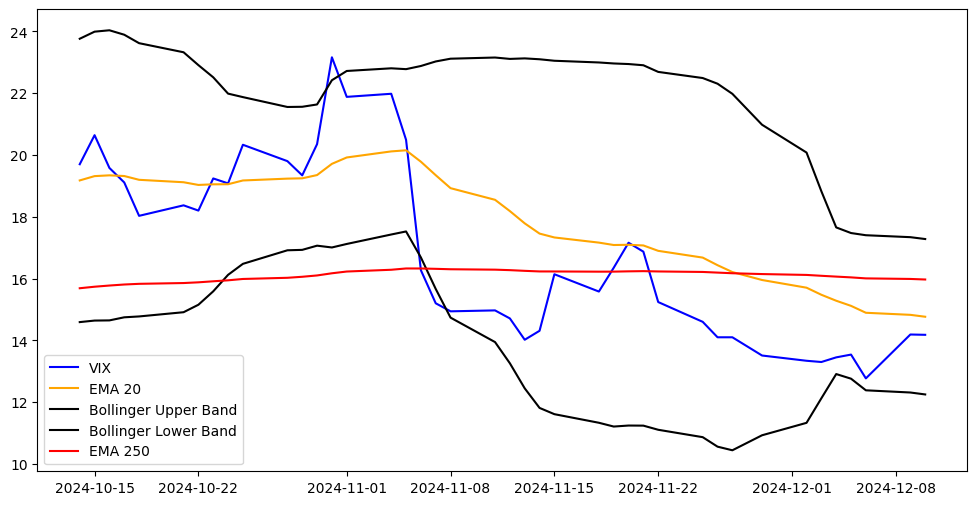

              VIX  EMA_short   EMA_long  pct_change       std  upper_band  \
Data                                                                        
2023-12-12  12.07  12.070000  12.070000         NaN       NaN         NaN   
2023-12-13  12.19  12.081428  12.071194    0.009942       NaN         NaN   
2023-12-14  12.48  12.119387  12.075261    0.023790       NaN         NaN   
2023-12-15  12.28  12.134684  12.077299   -0.016026       NaN         NaN   
2023-12-18  12.56  12.175190  12.082102    0.022801       NaN         NaN   
...           ...        ...        ...         ...       ...         ...   
2024-12-04  13.45  15.282739  16.063543    0.011278  1.186226   17.655191   
2024-12-05  13.54  15.116764  16.038433    0.006691  1.178296   17.473356   
2024-12-06  12.77  14.893262  16.005912   -0.056869  1.254600   17.402462   
2024-12-09  14.19  14.826285  15.987843    0.111198  1.256683   17.339650   
2024-12-10  14.18  14.764734  15.969854   -0.000705  1.257270   17.279274   

In [285]:
view_start_date = pd.to_datetime('today') - pd.Timedelta(days=60)
df_filtered = df[df.index >= view_start_date]


plt.figure(figsize=(12, 6))
plt.plot(df_filtered['VIX'], label='VIX',color="blue")
plt.plot(df_filtered['EMA_short'], label='EMA 20',color="orange")
plt.plot(df_filtered['upper_band'], label='Bollinger Upper Band',color="black")
plt.plot(df_filtered['lower_band'], label='Bollinger Lower Band',color="black")
plt.plot(df_filtered['EMA_long'], label='EMA 250',color="red")
plt.legend()
plt.show()

# Visualizza il dataframe con il semaforo
print(df)

In [286]:
df_filtered.to_excel('C:\C.Documents\\01 personale\\04 INVESTIMENTI\\codice\\VIX_Storico.xlsx', index=True)

In [282]:
df_filtered["Semaforo"]

Data
2024-10-14                     Giallo
2024-10-15                     Giallo
2024-10-16                     Giallo
2024-10-17                      Verde
2024-10-18                      Verde
2024-10-21                      Verde
2024-10-22                      Verde
2024-10-23                     Giallo
2024-10-24                     Giallo
2024-10-25                     Giallo
2024-10-28                     Giallo
2024-10-29                     Giallo
2024-10-30                     Giallo
2024-10-31    Rosso (Strong Movement)
2024-11-01                     Giallo
2024-11-04                     Giallo
2024-11-05                     Giallo
2024-11-06                      Verde
2024-11-07                      Verde
2024-11-08                      Verde
2024-11-11                      Verde
2024-11-12                      Verde
2024-11-13                      Verde
2024-11-14                      Verde
2024-11-15                      Verde
2024-11-18                      Verde
2024-11